<a href="https://colab.research.google.com/github/alammobaDar/CCADMACL_PROJECT_COM231ML/blob/main/CLUSTERING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [296]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

## Load Dataset

In [297]:
drive.mount("/content/drive")

path = "/content/drive/My Drive/Datasets/new_flows_sampled_8000.csv"

pd.set_option('display.max_columns', None)

df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [298]:
df.head()

,packet_count,byte_count,avg_pkt_len,max_pkt_len,min_pkt_len,start_time,end_time,first_ip_src,flow_duration,avg_iat_micros,pkt_len_range,bytes_out,bytes_in,payload_ratio,p1_len,p2_len,p3_len,p4_len,p5_len,small_iat_count,burst_ratio,ip_src,ip_dst,src_port,dst_port,proto
0,103,12016.0,116.660194,152.0,83.0,1.744194e+09,1.744194e+09,163.164.81.189,6.209432e+07,602857,69.0,12016.0,0.0,0.000000,152.0,83.0,152.0,83.0,152.0,5.0,0.048544,163.164.81.189,198.4.52.90,7844.0,56590.0,17.0
1,8,2616.0,327.000000,476.0,178.0,1.744194e+09,1.744194e+09,131.113.197.140,2.385329e+06,298166,298.0,1904.0,712.0,0.373753,476.0,476.0,178.0,178.0,476.0,4.0,0.500000,131.113.197.140,135.149.180.143,11335.0,48674.0,17.0
2,5,400.0,80.000000,80.0,80.0,1.744194e+09,1.744194e+09,211.255.35.226,7.045438e+06,1409087,0.0,400.0,0.0,0.000000,80.0,80.0,80.0,80.0,80.0,0.0,0.000000,192.216.221.104,211.255.35.226,53.0,49584.0,17.0
3,261,16682.0,63.915709,70.0,60.0,1.744194e+09,1.744194e+09,154.86.217.17,1.712990e+07,65631,10.0,16682.0,0.0,0.000000,65.0,65.0,70.0,70.0,70.0,20.0,0.076628,154.86.217.17,163.164.202.195,80.0,3702.0,17.0
4,119,16422.0,138.000000,138.0,138.0,1.744194e+09,1.744194e+09,157.173.5.221,7.575309e+06,63658,0.0,16422.0,0.0,0.000000,138.0,138.0,138.0,138.0,138.0,0.0,0.000000,157.173.5.221,183.199.114.40,10521.0,46712.0,17.0


In [299]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   packet_count     8000 non-null   int64  
 1   byte_count       8000 non-null   float64
 2   avg_pkt_len      8000 non-null   float64
 3   max_pkt_len      8000 non-null   float64
 4   min_pkt_len      8000 non-null   float64
 5   start_time       8000 non-null   float64
 6   end_time         8000 non-null   float64
 7   first_ip_src     8000 non-null   object 
 8   flow_duration    8000 non-null   float64
 9   avg_iat_micros   8000 non-null   int64  
 10  pkt_len_range    8000 non-null   float64
 11  bytes_out        8000 non-null   float64
 12  bytes_in         8000 non-null   float64
 13  payload_ratio    8000 non-null   float64
 14  p1_len           8000 non-null   float64
 15  p2_len           8000 non-null   float64
 16  p3_len           8000 non-null   float64
 17  p4_len        

In [300]:
df.describe()

,packet_count,byte_count,avg_pkt_len,max_pkt_len,min_pkt_len,start_time,end_time,flow_duration,avg_iat_micros,pkt_len_range,bytes_out,bytes_in,payload_ratio,p1_len,p2_len,p3_len,p4_len,p5_len,small_iat_count,burst_ratio,src_port,dst_port,proto
count,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.000000,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8000.000000,8.000000e+03,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,38.943500,1.801323e+04,259.316959,787.647625,76.177250,1.744194e+09,1.744194e+09,1.707495e+07,1.389701e+06,711.470375,1.124790e+04,6.765332e+03,1.076794,184.266000,266.187625,404.600625,322.264875,277.062625,15.529250,0.315555,6902.608250,47751.420625,11.500000
std,131.576005,1.306287e+05,349.316348,1479.295736,70.387894,1.857357e+01,1.819381e+01,2.124788e+07,2.226949e+06,1482.951000,8.324051e+04,9.992718e+04,7.388711,327.587194,442.379651,707.545218,508.672496,473.046785,80.045319,0.250173,12906.124264,15572.886346,5.500344
min,5.000000,2.700000e+02,54.000000,54.000000,54.000000,1.744194e+09,1.744194e+09,5.960464e+00,1.000000e+00,0.000000,5.400000e+01,0.000000e+00,0.000000,54.000000,54.000000,54.000000,54.000000,54.000000,0.000000,0.000000,17.000000,53.000000,6.000000
25%,7.000000,6.300000e+02,78.000000,90.000000,54.000000,1.744194e+09,1.744194e+09,2.646171e+05,2.017775e+04,12.000000,5.127500e+02,0.000000e+00,0.000000,70.000000,66.000000,66.000000,66.000000,66.000000,1.000000,0.083333,443.000000,40645.750000,6.000000
50%,10.000000,1.432000e+03,126.111111,259.000000,66.000000,1.744194e+09,1.744194e+09,6.833227e+06,3.446855e+05,171.500000,1.189000e+03,0.000000e+00,0.000000,78.000000,74.000000,94.000000,88.000000,90.000000,3.000000,0.333333,443.000000,52707.000000,11.500000
75%,19.000000,6.871500e+03,313.621992,1292.000000,74.000000,1.744194e+09,1.744194e+09,3.100339e+07,1.764702e+06,1207.000000,5.592250e+03,2.640000e+02,0.753606,92.000000,149.250000,279.250000,237.000000,183.000000,7.000000,0.500000,8080.000000,59099.250000,17.000000
max,1905.000000,4.848086e+06,8346.093240,23414.000000,1392.000000,1.744194e+09,1.744194e+09,6.246210e+07,1.235066e+07,23360.000000,4.581937e+06,4.827654e+06,246.698028,4290.000000,4162.000000,12252.000000,8803.000000,10557.000000,1671.000000,0.994056,64044.000000,65529.000000,17.000000


In [301]:
df.isna().sum()

,0
packet_count,0
byte_count,0
avg_pkt_len,0
max_pkt_len,0
min_pkt_len,0
start_time,0
end_time,0
first_ip_src,0
flow_duration,0
avg_iat_micros,0


In [302]:
# Remove object types

X = df.drop(["ip_src", "ip_dst", "start_time", "end_time", "src_port", "dst_port", "proto", "first_ip_src", "p1_len", "p2_len", "p3_len", "p4_len", "p5_len", "avg_pkt_len", "min_pkt_len"], axis=1)

In [303]:
X.head()

,packet_count,byte_count,max_pkt_len,flow_duration,avg_iat_micros,pkt_len_range,bytes_out,bytes_in,payload_ratio,small_iat_count,burst_ratio
0,103,12016.0,152.0,6.209432e+07,602857,69.0,12016.0,0.0,0.000000,5.0,0.048544
1,8,2616.0,476.0,2.385329e+06,298166,298.0,1904.0,712.0,0.373753,4.0,0.500000
2,5,400.0,80.0,7.045438e+06,1409087,0.0,400.0,0.0,0.000000,0.0,0.000000
3,261,16682.0,70.0,1.712990e+07,65631,10.0,16682.0,0.0,0.000000,20.0,0.076628
4,119,16422.0,138.0,7.575309e+06,63658,0.0,16422.0,0.0,0.000000,0.0,0.000000


## Initial visualisation of the dataset

<Axes: >

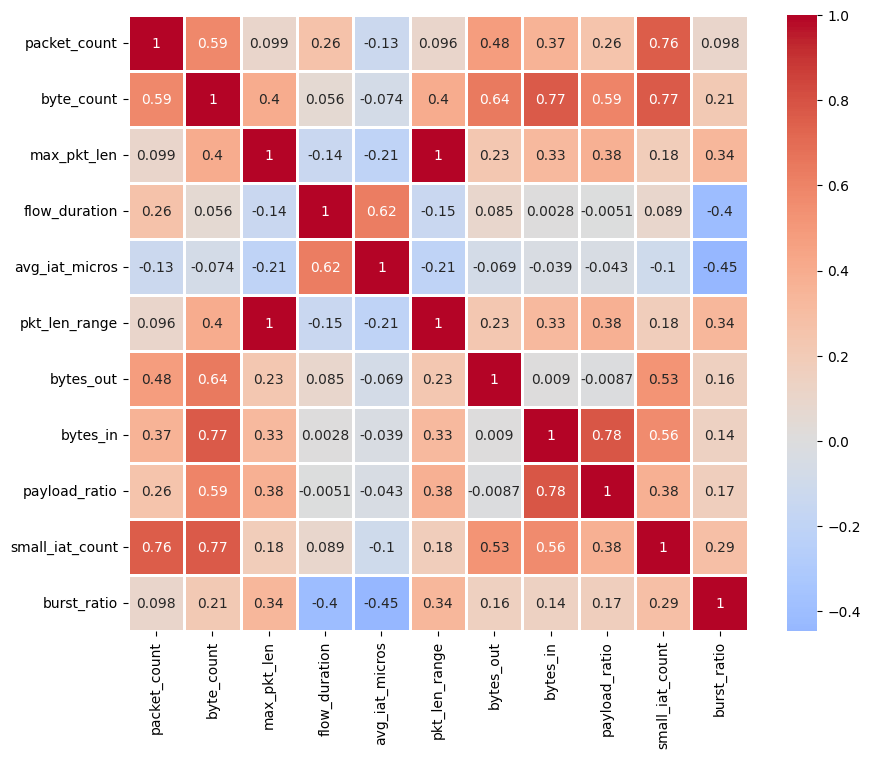

In [304]:
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), cmap="coolwarm", center=0, annot=True, linewidths=2)

In [305]:
# sns.pairplot(X)

In [306]:
kmeansX = X.drop(["max_pkt_len"], axis=1)
dbX = X.drop(["max_pkt_len"], axis=1)
hdbX = X.drop(["max_pkt_len"], axis=1)
gmmX = X.drop(["max_pkt_len"], axis=1)

## Scale Data

### Standard Scaler

In [307]:
sscaler = StandardScaler()
X_sscaled = sscaler.fit_transform(X)

X_sscaled = pd.DataFrame(X_sscaled, columns=X.columns)

In [308]:
X_sscaled.head()

,packet_count,byte_count,max_pkt_len,flow_duration,avg_iat_micros,pkt_len_range,bytes_out,bytes_in,payload_ratio,small_iat_count,burst_ratio
0,0.486871,-0.045913,-0.429723,2.118903,-0.353350,-0.433265,0.009228,-0.067707,-0.145744,-0.131549,-1.067373
1,-0.235191,-0.117878,-0.210686,-0.691388,-0.490179,-0.278833,-0.112259,-0.060581,-0.095157,-0.144043,0.737314
2,-0.257992,-0.134843,-0.478398,-0.472053,0.008706,-0.479797,-0.130328,-0.067707,-0.145744,-0.194018,-1.261425
3,1.687773,-0.010192,-0.485158,0.002587,-0.594604,-0.473053,0.065286,-0.067707,-0.145744,0.055856,-0.955105
4,0.608481,-0.012182,-0.439188,-0.447114,-0.595490,-0.479797,0.062162,-0.067707,-0.145744,-0.194018,-1.261425


### Robust Scaler

In [309]:
rscaler = RobustScaler()
X_rscaled = rscaler.fit_transform(X)

X_rscaled = pd.DataFrame(X_rscaled, columns=X.columns)

In [310]:
X_rscaled.head()

,packet_count,byte_count,max_pkt_len,flow_duration,avg_iat_micros,pkt_len_range,bytes_out,bytes_in,payload_ratio,small_iat_count,burst_ratio
0,7.750000,1.695746,-0.089018,1.797765,0.147990,-0.085774,2.131509,0.00000,0.000000,0.333333,-0.683495
1,-0.166667,0.189698,0.180532,-0.144700,-0.026666,0.105858,0.140762,2.69697,0.495953,0.166667,0.400000
2,-0.416667,-0.165345,-0.148918,0.006904,0.610139,-0.143515,-0.155330,0.00000,0.000000,-0.500000,-0.800000
3,20.916667,2.443323,-0.157238,0.334973,-0.159960,-0.135146,3.050103,0.00000,0.000000,2.833333,-0.616092
4,9.083333,2.401666,-0.100666,0.024142,-0.161091,-0.143515,2.998917,0.00000,0.000000,-0.500000,-0.800000


# PCA IMPLEMENTATION

In [311]:
def reduce_dimensions(X, n_components, is2_dim=True):
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)

    print("Number of components kept:", pca.n_components_)
    print("Explained variance ratio:", pca.explained_variance_ratio_)
    print("Total variance retained:", sum(pca.explained_variance_ratio_))

    if is2_dim:
      loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
      loading_matrix = pd.DataFrame(loadings, columns=[f"PC{i}" for i in range(pca.n_components)], index=X.columns)
    else:
      loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
      loading_matrix = pd.DataFrame(loadings, columns=[f"PC{i}" for i in range(pca.n_components_)], index=X.columns)

    sns.heatmap(loading_matrix, annot=True)
    plt.show()

    return X_reduced

def correlational_heatmap(X):
    plt.figure(figsize=(10, 8))
    sns.heatmap(X.corr(), annot=True, cmap="coolwarm")

def visualize_reduced_data(X, X_reduced, is2_dim=True):
    if is2_dim:
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

      ax2.scatter(X_reduced[:,0], X_reduced[:,1])
      ax2.set_title("Scatter plot of reduced data")
      ax2.set_xlabel("PC1")
      ax2.set_ylabel("PC2")

    else:
      fig, ax1 = plt.subplots(1, 1, figsize=(20, 6))

    ax1.boxplot(X, tick_labels=X.columns)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.set_title("Box Plot of scaled data")
    ax1.set_xlabel("Features")
    ax1.set_ylabel("Values")

    plt.show()

    import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import RobustScaler # Using RobustScaler as we discussed!

def plot_diagnostics(data_scaled):
    plt.figure(figsize=(14, 5))

    # --- SUBPLOT 1: PCA EXPLAINED VARIANCE ---
    pca = PCA().fit(data_scaled)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
    plt.axhline(y=0.90, color='r', linestyle='-', label='90% Threshold')
    plt.title('PCA: Cumulative Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Output the exact number for 90% variance
    n_90 = np.where(cumulative_variance >= 0.90)[0][0] + 1
    print(f"--- DIAGNOSIS ---")
    print(f"To capture 90% of information, you need: {n_90} components.")

## PCA (Standard Scaler)

Number of components kept: 2
Explained variance ratio: [0.38085068 0.20232373]
Total variance retained: 0.5831744071009952


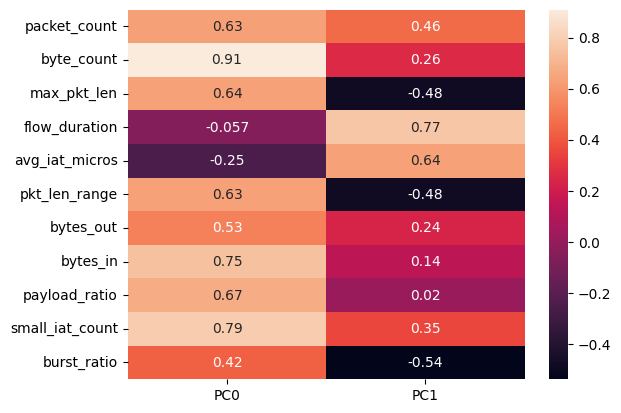

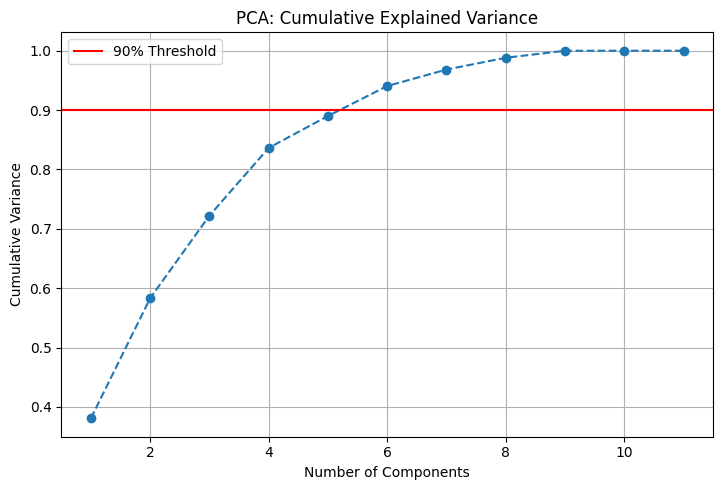

--- DIAGNOSIS ---
To capture 90% of information, you need: 6 components.


In [312]:
X_sscaled_reduced= reduce_dimensions(X_sscaled, 2)

plot_diagnostics(X_sscaled)

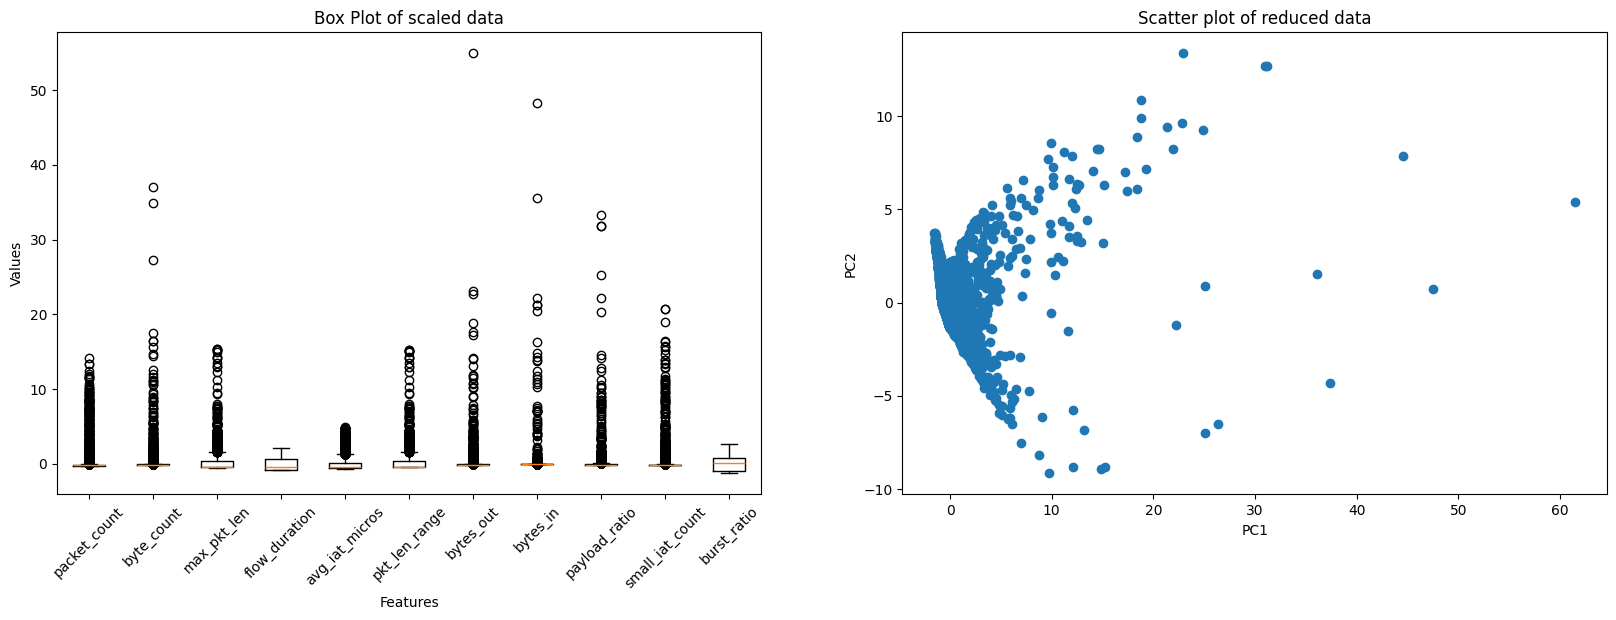

In [313]:
visualize_reduced_data(X_sscaled, X_sscaled_reduced)

## PCA (Robust Scaler)

Number of components kept: 2
Explained variance ratio: [0.99506058 0.00376232]
Total variance retained: 0.998822896167855


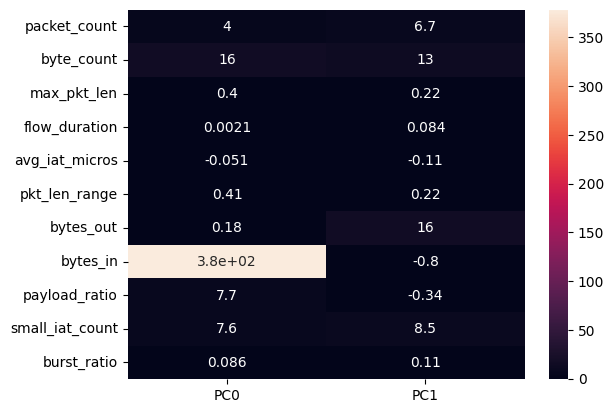

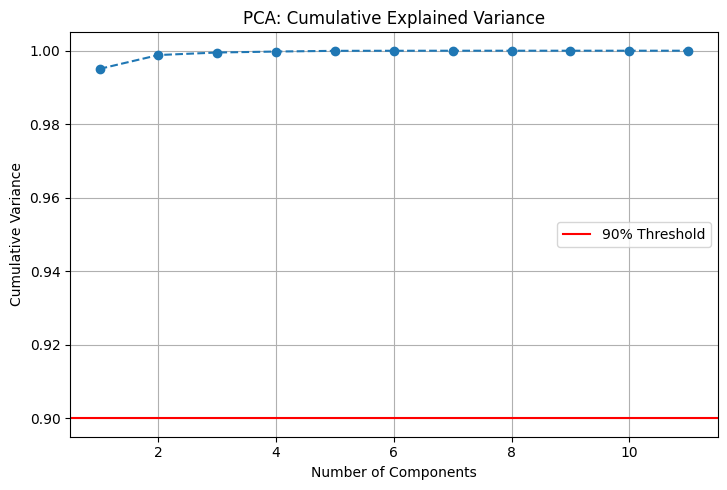

--- DIAGNOSIS ---
To capture 90% of information, you need: 1 components.


In [314]:
X_rscaled_reduced = reduce_dimensions(X_rscaled, 2)
plot_diagnostics(X_rscaled)

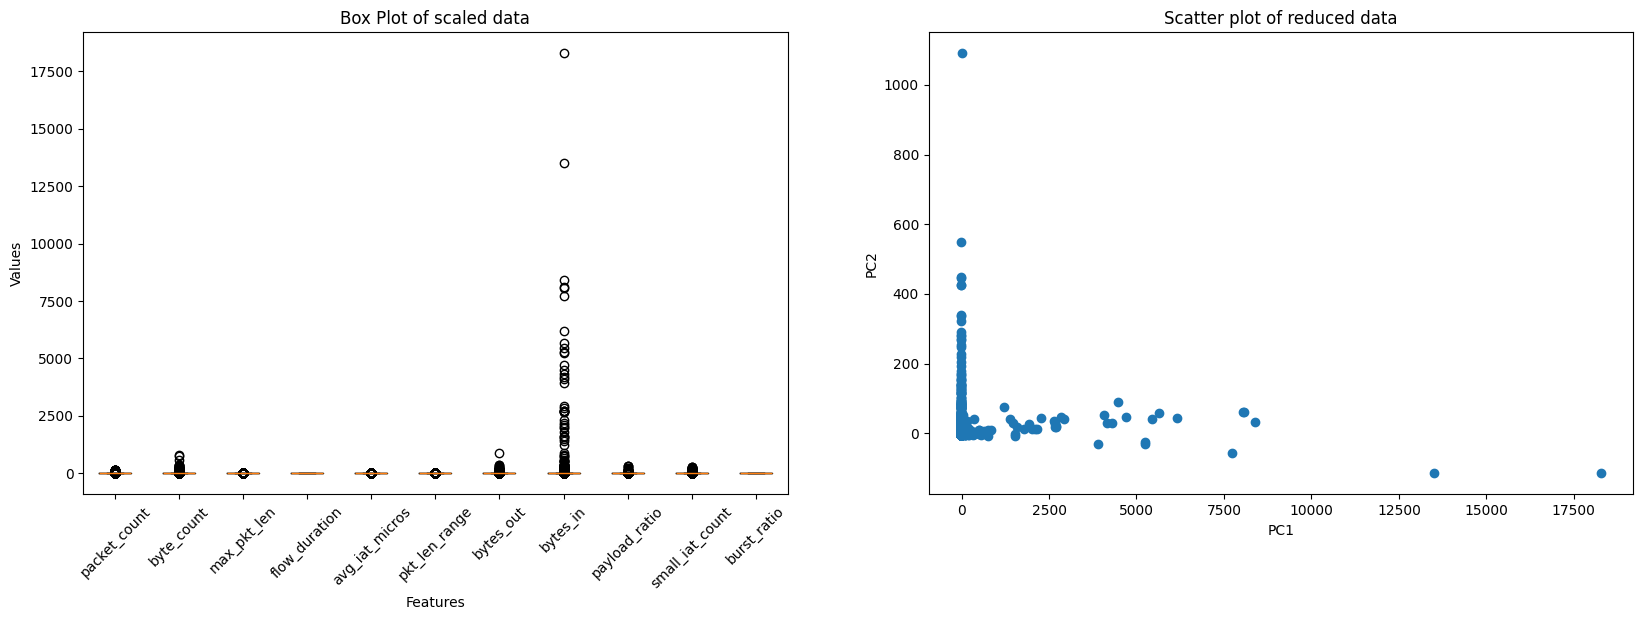

In [315]:
visualize_reduced_data(X_rscaled, X_rscaled_reduced)

***Based on the results of base PCA with Standard / Robust Scaler is not reliable for our datasets we are going to try to work around with PCA***

# PCA Workaround

Number of components kept: 4
Explained variance ratio: [0.44597645 0.20726157 0.18289475 0.07812439]
Total variance retained: 0.9142571679653098


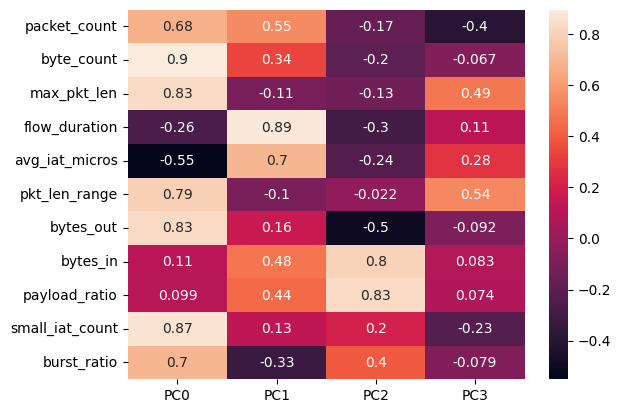

Number of components kept: 4
Explained variance ratio: [0.45865781 0.2482563  0.15979784 0.0579891 ]
Total variance retained: 0.9247010458584994


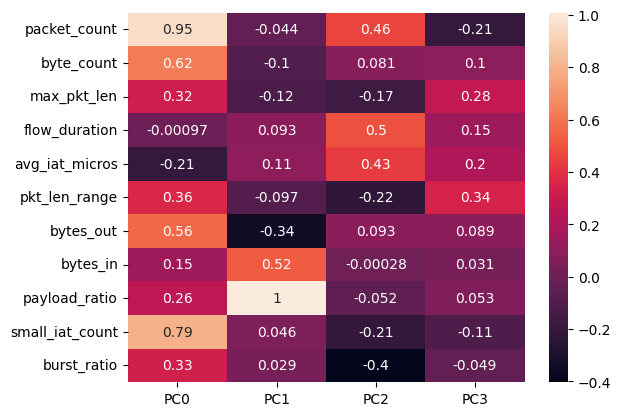

In [316]:
# Log Transform

x_log = np.log1p(X)
x_log = pd.DataFrame(x_log, columns=X.columns)

x_log_sscaled = sscaler.fit_transform(x_log)
x_log_sscaled = pd.DataFrame(x_log_sscaled, columns=X.columns)
x_log_sscaled_reduced = reduce_dimensions(x_log_sscaled, 0.9, is2_dim=False)

# visualize_reduced_data(x_log, x_log_sscaled_reduced, is2_dim=False)

x_log_rscaled = rscaler.fit_transform(x_log)
x_log_rscaled = pd.DataFrame(x_log_rscaled, columns=X.columns)
x_log_rscaled_reduced = reduce_dimensions(x_log_rscaled, 0.9, is2_dim=False)

# visualize_reduced_data(x_log, x_log_rscaled_reduced, is2_dim=False)

 ***We are going to use Robust Scaler here since it has better spread than Standard Scaler***

## KMEANS Implementation

In [317]:
def elbow_method(X):
  wcss = []
  sse = {}
  for i in range(1, 11):
      kmeans =  KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
      kmeans.fit(X)

      wcss.append(kmeans.inertia_)
      sse[i] = kmeans.inertia_
      print(f"For cluster = {i}, SSE/WCSS is {sse[i]}")

  plt.plot(range(1, 11), wcss)
  plt.title("Elbow method")
  plt.xlabel("Number of cluster")
  plt.ylabel("WCSS")
  plt.show()

def handle_kmeans(X, n_clusters):
  kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
  clusters = kmeans.fit_predict(X)

  return kmeans, clusters

def kmeans_metrics(X, clusters):
  silhouette_avg = silhouette_score(X, clusters)
  dbs = davies_bouldin_score(X, clusters)
  chs = calinski_harabasz_score(X, clusters)

  print(f"Silhouette Score: {silhouette_avg}")
  print(f"Davies-Bouldin Score: {dbs}")
  print(f"Calinski-Harabasz Score: {chs}")

For cluster = 1, SSE/WCSS is 43676.69029052554
For cluster = 2, SSE/WCSS is 29805.030175248467
For cluster = 3, SSE/WCSS is 23086.99563149402
For cluster = 4, SSE/WCSS is 18823.54946991786
For cluster = 5, SSE/WCSS is 15441.938549630207
For cluster = 6, SSE/WCSS is 13288.85671390148
For cluster = 7, SSE/WCSS is 11324.197382636681
For cluster = 8, SSE/WCSS is 9679.090197498243
For cluster = 9, SSE/WCSS is 8775.790390075275
For cluster = 10, SSE/WCSS is 8104.827674305872


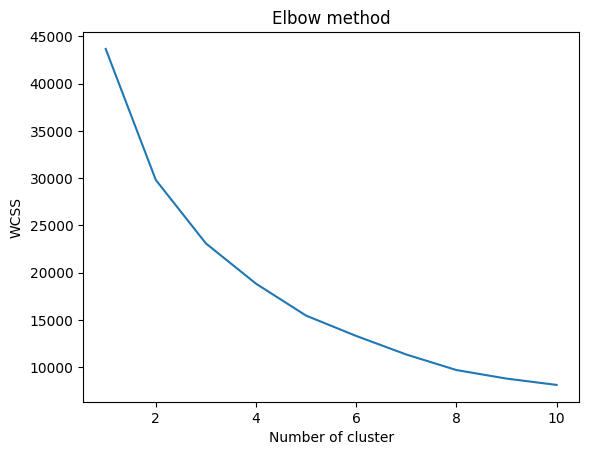

In [318]:
elbow_method(x_log_rscaled_reduced)

In [319]:
# Robust Scaler
rkmeans, rcluster = handle_kmeans(x_log_rscaled_reduced, 5)

kmeans_metrics(x_log_rscaled_reduced, rcluster)

Silhouette Score: 0.3674557862191687
Davies-Bouldin Score: 1.0386866805695982
Calinski-Harabasz Score: 3654.39604753065


In [320]:
# Standard Scaler
skmeans, scluster = handle_kmeans(x_log_sscaled_reduced, 5)

kmeans_metrics(x_log_sscaled_reduced, scluster)

Silhouette Score: 0.326047746944525
Davies-Bouldin Score: 1.1581412460605751
Calinski-Harabasz Score: 3431.3211959896184


In [321]:
df["cluster"] = rcluster

df["cluster"].value_counts()

kmeansX["cluster"] = rcluster

kmeansX["cluster"].value_counts()


,count
cluster,
1,2753
0,2289
4,1413
2,838
3,707


In [322]:
import plotly.express as px
import numpy as np

# 1. Map your Cluster IDs to your Thesis Labels
# Based on the profiles we saw: 0=Background, 1=Browsing, 2=VoIP, 3=Streaming
cluster_names = {
    0: "Gaming / Highly Interactive",
    1: "Streaming / Video",
    2: "Heavy Upload / Cloud Sync",
    3: "Web Browsing / Control",
    4: "others",
    5: "others1"
}

# Assign the cluster labels to the original df DataFrame
kmeansX['cluster'] = rcluster
kmeansX['cluster_label'] = kmeansX['cluster'].map(cluster_names)

# 2. Fix the Sizing Logic
# We use log1p to compress the size range so points aren't invisible
# Then we add a constant (+5) so the smallest points are still clickable
point_size = np.log1p(df['packet_count']) + 5

fig = px.scatter_3d(
    kmeansX,
    x=x_log_rscaled_reduced[:, 0],
    y=x_log_rscaled_reduced[:, 1],
    z=x_log_rscaled_reduced[:, 2],
    color='cluster_label', # Use the labels for the legend
    symbol='cluster_label',
    size=point_size,       # Scaled sizes
    opacity=1,
    hover_data={           # See features when you hover over a point
        'packet_count': True,
        'byte_count': True,
        'payload_ratio': ':.2f',
        'small_iat_count': True
    },
    title="3D Behavioral Clustering of Encrypted Traffic",
    labels={'x': 'PC0 (Duration/IAT)', 'y': 'PC1 (Identity)', 'z': 'PC2 (Symmetry)'},
    color_discrete_sequence=px.colors.qualitative.Vivid
)

# 3. Clean up the layout
fig.update_layout(
    legend_title_text='Activity Type',
    margin=dict(l=0, r=0, b=0, t=40),
    scene=dict(
        xaxis_title='Duration/IAT',
        yaxis_title='Identity (P1-P5)',
        zaxis_title='Symmetry (Ratio)'
    )
)

fig.show()

In [323]:
# Check the 'Behavioral DNA' of each cluster
profile = df.groupby('cluster').agg({
    'packet_count': 'mean',
    'bytes_out': 'mean',
    'bytes_in': 'mean',
    'payload_ratio': 'mean',
    'burst_ratio': 'mean',
    'small_iat_count': 'mean',
    'avg_iat_micros': 'mean',
    'avg_pkt_len': 'mean',
    'min_pkt_len': 'mean',
    'byte_count': 'mean',
    'flow_duration': 'mean',
    'p1_len': 'mean',
    'p2_len': 'mean',
    'p3_len': 'mean',
    'p4_len': 'mean',
    'p5_len': 'mean',
    'max_pkt_len': 'mean'

}).round(2)
profile.head()

,packet_count,bytes_out,bytes_in,payload_ratio,burst_ratio,small_iat_count,avg_iat_micros,avg_pkt_len,min_pkt_len,byte_count,flow_duration,p1_len,p2_len,p3_len,p4_len,p5_len,max_pkt_len
cluster,,,,,,,,,,,,,,,,,
0,10.91,1314.85,26.04,0.03,0.08,0.70,3411604.32,124.10,86.20,1340.89,29251118.50,114.41,112.38,130.13,118.74,132.50,195.59
1,11.90,4525.90,41.15,0.02,0.46,5.63,211728.21,352.38,70.57,4567.05,3071853.20,217.77,424.41,800.87,521.24,412.42,1133.90
2,209.66,83698.33,1798.20,0.10,0.37,72.09,398408.74,428.83,90.29,85496.53,36379234.17,260.36,376.81,453.05,430.21,388.65,1195.30
3,93.56,5566.30,73225.72,8.23,0.52,61.29,421023.82,477.45,67.41,78792.03,20338142.63,386.38,387.17,333.62,517.46,452.73,2156.96
4,8.47,310.78,475.78,1.82,0.29,2.39,1481973.57,87.38,66.89,786.56,11551369.65,85.88,80.94,83.94,102.61,93.44,145.22


***Insights:*** *we won't test Standard Scaler anymore and we will use Robust Scaler*

In [324]:
kmeans_cluster =  {
    0: "Background / Control",
    1: "Web Browsing",
    2: "Streaming",
    3: "Gaming"
}


df['cluster'] = rcluster
df['cluster_label'] = df['cluster'].map(kmeans_cluster)

In [325]:
df.head()

,packet_count,byte_count,avg_pkt_len,max_pkt_len,min_pkt_len,start_time,end_time,first_ip_src,flow_duration,avg_iat_micros,pkt_len_range,bytes_out,bytes_in,payload_ratio,p1_len,p2_len,p3_len,p4_len,p5_len,small_iat_count,burst_ratio,ip_src,ip_dst,src_port,dst_port,proto,cluster,cluster_label
0,103,12016.0,116.660194,152.0,83.0,1.744194e+09,1.744194e+09,163.164.81.189,6.209432e+07,602857,69.0,12016.0,0.0,0.000000,152.0,83.0,152.0,83.0,152.0,5.0,0.048544,163.164.81.189,198.4.52.90,7844.0,56590.0,17.0,2,Streaming
1,8,2616.0,327.000000,476.0,178.0,1.744194e+09,1.744194e+09,131.113.197.140,2.385329e+06,298166,298.0,1904.0,712.0,0.373753,476.0,476.0,178.0,178.0,476.0,4.0,0.500000,131.113.197.140,135.149.180.143,11335.0,48674.0,17.0,1,Web Browsing
2,5,400.0,80.000000,80.0,80.0,1.744194e+09,1.744194e+09,211.255.35.226,7.045438e+06,1409087,0.0,400.0,0.0,0.000000,80.0,80.0,80.0,80.0,80.0,0.0,0.000000,192.216.221.104,211.255.35.226,53.0,49584.0,17.0,0,Background / Control
3,261,16682.0,63.915709,70.0,60.0,1.744194e+09,1.744194e+09,154.86.217.17,1.712990e+07,65631,10.0,16682.0,0.0,0.000000,65.0,65.0,70.0,70.0,70.0,20.0,0.076628,154.86.217.17,163.164.202.195,80.0,3702.0,17.0,2,Streaming
4,119,16422.0,138.000000,138.0,138.0,1.744194e+09,1.744194e+09,157.173.5.221,7.575309e+06,63658,0.0,16422.0,0.0,0.000000,138.0,138.0,138.0,138.0,138.0,0.0,0.000000,157.173.5.221,183.199.114.40,10521.0,46712.0,17.0,2,Streaming


In [326]:
cluster_0_data = df[df["cluster"] == 0].sample(10)

print(cluster_0_data)

      packet_count  byte_count  avg_pkt_len  max_pkt_len  min_pkt_len  \
5367            12       972.0    81.000000        108.0         54.0   
4826            14      1200.0    85.714286        111.0         54.0   
1998            39      2772.0    71.076923        120.0         67.0   
1745             5       376.0    75.200000         82.0         72.0   
5182             9       640.0    71.111111         76.0         54.0   
7909             8       472.0    59.000000         74.0         54.0   
2717             6       928.0   154.666667        214.0        114.0   
5575             9      2482.0   275.777778        544.0         54.0   
2149             6       924.0   154.000000        154.0        154.0   
4716            11       771.0    70.090909         74.0         54.0   

        start_time      end_time    first_ip_src  flow_duration  \
5367  1.744194e+09  1.744194e+09  150.67.232.126   5.006764e+07   
4826  1.744194e+09  1.744194e+09   150.67.84.173   5.006467e+0

In [327]:
cluster_1_data = df[df["cluster"] == 1].sample(10)

print(cluster_1_data)

      packet_count  byte_count  avg_pkt_len  max_pkt_len  min_pkt_len  \
775             18     13078.0   726.555556       1292.0         64.0   
298             12      1836.0   153.000000        411.0         70.0   
2519            12      5104.0   425.333333       1292.0         63.0   
4920            12      2163.0   180.250000       1426.0         54.0   
3747            24     15568.0   648.666667       1292.0         83.0   
4430            10      2056.0   205.600000        829.0         66.0   
6640            10      1189.0   118.900000        427.0         54.0   
7704            18     11060.0   614.444444       4485.0         66.0   
7574            10      1189.0   118.900000        427.0         54.0   
85               8       752.0    94.000000         94.0         94.0   

        start_time      end_time     first_ip_src  flow_duration  \
775   1.744194e+09  1.744194e+09    142.30.207.32   4.012799e+05   
298   1.744194e+09  1.744194e+09    126.36.228.42   5.277832

In [328]:
cluster_2_data = df[df["cluster"] == 2].sample(10)

print(cluster_2_data)

      packet_count  byte_count  avg_pkt_len  max_pkt_len  min_pkt_len  \
1292            82     16964.0   206.878049        926.0         60.0   
3170           108     57915.0   536.250000       1292.0         83.0   
2305            70      7384.0   105.485714        130.0         87.0   
1506            50     39600.0   792.000000        792.0        792.0   
889             85     12070.0   142.000000        142.0        142.0   
2025            53      5040.0    95.094340       1157.0         63.0   
2698          1529    317107.0   207.395029        360.0        106.0   
263            178    155339.0   872.691011       1242.0         71.0   
38             112     15456.0   138.000000        138.0        138.0   
1287            32     32773.0  1024.156250       1242.0         68.0   

        start_time      end_time     first_ip_src  flow_duration  \
1292  1.744194e+09  1.744194e+09  221.113.193.148   6.012499e+07   
3170  1.744194e+09  1.744194e+09    133.28.53.148   3.130578

In [329]:
cluster_3_data = df[df["cluster"] == 3].sample(10)

print(cluster_3_data)

      packet_count  byte_count  avg_pkt_len  max_pkt_len  min_pkt_len  \
7359            29      5320.0   183.448276       1514.0         66.0   
4132            27     11323.0   419.370370       2690.0         54.0   
3632           150     93255.0   621.700000       1292.0         64.0   
697             48     30534.0   636.125000       1292.0         65.0   
7414            25      5163.0   206.520000       1554.0         54.0   
3789            27      8393.0   310.851852        671.0         70.0   
2008            17      7261.0   427.117647       1292.0         66.0   
964            107     33269.0   310.925234        774.0        128.0   
1846            23     15895.0   691.086957       1392.0         70.0   
131            243     44188.0   181.843621        311.0        103.0   

        start_time      end_time    first_ip_src  flow_duration  \
7359  1.744194e+09  1.744194e+09  195.47.191.212   3.337312e+07   
4132  1.744194e+09  1.744194e+09  150.67.189.182   2.063859e+0

# DBSCAN Implementation

In [330]:
def knee_method(X):
  nn = NearestNeighbors(n_neighbors=10)
  nn.fit(X)
  distances, indices = nn.kneighbors(X)

  distab = np.sort(distances, axis=0)
  distab = distab[:, 3]
  plt.figure(figsize=(10,8))
  plt.plot(distab)

  return distab

def check_optimal_eps(distab):
  x = np.arange(len(distab))
  y = distab

  x1, y1 = x[0], y[0]
  x2, y2 = x[-1], y[-1]

  numerator = np.abs((y2 - y1) * x - (x2 - x1) * y + x2*y1 - y2*x1)
  denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)

  distances_to_line = numerator / denominator

  elbow_idx = np.argmax(distances_to_line)
  elbow_value = y[elbow_idx]

  print("Optimal eps:", elbow_value)

  return elbow_value

def check_optimal_min_samples(X, eps):
  min_samples=range(1,15)
  ep = eps
  for min_sample in min_samples:
      db = DBSCAN(eps=ep, min_samples=min_sample, metric="euclidean")
      db.fit(X)
      labels = db.labels_
      n_noise = list(labels).count(-1)
      n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
      print(f"min_samples={min_sample}: clusters={n_clusters}: noise points={n_noise}")


Optimal eps: 0.3976320373199688
min_samples=1: clusters=21: noise points=0
min_samples=2: clusters=4: noise points=17
min_samples=3: clusters=4: noise points=17
min_samples=4: clusters=4: noise points=23
min_samples=5: clusters=4: noise points=25
min_samples=6: clusters=4: noise points=32
min_samples=7: clusters=6: noise points=36
min_samples=8: clusters=5: noise points=43
min_samples=9: clusters=3: noise points=57
min_samples=10: clusters=3: noise points=61
min_samples=11: clusters=3: noise points=63
min_samples=12: clusters=2: noise points=75
min_samples=13: clusters=1: noise points=90
min_samples=14: clusters=1: noise points=91


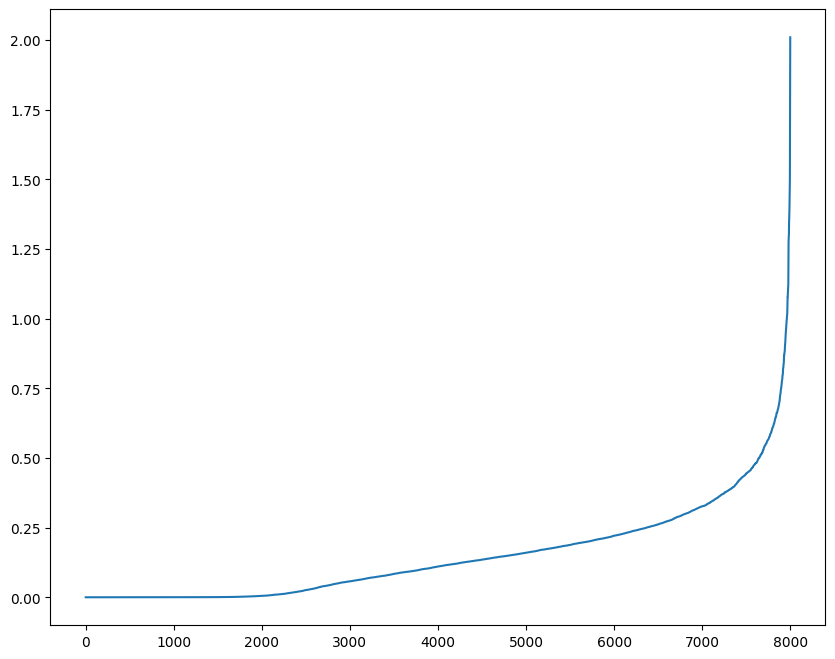

In [331]:
distab = knee_method(x_log_rscaled_reduced)

eps = check_optimal_eps(distab)

check_optimal_min_samples(x_log_rscaled_reduced, 1)

In [332]:
db = DBSCAN(eps=1, min_samples=4, metric="euclidean")
db.fit(x_log_rscaled_reduced)
labels = db.labels_

dbX["cluster"] = db.labels_

print(dbX["cluster"].value_counts())

cluster
 0    7948
-1      23
 3      13
 1      11
 2       5
Name: count, dtype: int64


In [333]:
px.scatter_3d(X,
              x=x_log_rscaled_reduced[:,0],
              y=x_log_rscaled_reduced[:,1],
              z=x_log_rscaled_reduced[:,2],
              color=dbX["cluster"],
              # size=dbX["flow_duration"],

              )

In [334]:
profile = dbX.groupby('cluster').agg({
    'packet_count': 'mean',
    # 'bytes_out': 'mean',
    'bytes_in': 'mean',
    'payload_ratio': 'mean',
    'burst_ratio': 'mean',
    'small_iat_count': 'mean',
    'avg_iat_micros': 'mean',
    # 'avg_pkt_len': 'mean',
    # 'min_pkt_len': 'mean',
    'byte_count': 'mean',
    'flow_duration': 'mean'
}).round(2)

print(profile)

         packet_count   bytes_in  payload_ratio  burst_ratio  small_iat_count  \
cluster                                                                         
-1             475.17  873292.74          81.73         0.78           354.70   
 0              37.66    4080.90           0.70         0.31            14.48   
 1              70.55   98521.82          60.95         0.85            60.36   
 2              20.40    1440.00          10.49         0.32             6.60   
 3              30.23   39304.31          32.44         0.74            22.92   

         avg_iat_micros  byte_count  flow_duration  
cluster                                             
-1             45219.26  1130840.22    14698566.49  
 0           1396540.92    14652.62    17063027.02  
 1            516278.09   100222.18    36802776.94  
 2           2091289.20     1576.40    42721882.96  
 3             55870.54    40553.23     2009750.51  


# HDBSCAN IMPLEMENTATION

In [335]:
import hdbscan
import pandas as pd
import numpy as np

# Define the ranges for tuning
# min_cluster_size: Smallest group you'd consider a "behavior"
# min_samples: Controls how conservative the clustering is (higher = more noise)
min_cluster_range = [5, 10, 15, 20, 25, 30, 35, 40]
min_samples_range = [1, 5, 10, 15, 20, 25, 30]

results = []

print("Starting Grid Search...")
print(f"{'Size':>5} | {'Samp':>5} | {'Clusters':>8} | {'Noise %':>8} | {'DBCV Score':>10}")
print("-" * 50)

for mcs in min_cluster_range:
    for ms in min_samples_range:
        # Initialize and fit
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=mcs,
            min_samples=ms,
            gen_min_span_tree=True
        )
        labels = clusterer.fit_predict(x_log_rscaled_reduced)

        # Calculate metrics
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_perc = (np.sum(labels == -1) / len(labels)) * 100
        dbcv_score = clusterer.relative_validity_ # This is the DBCV score

        results.append({
            'min_cluster_size': mcs,
            'min_samples': ms,
            'n_clusters': n_clusters,
            'noise_percentage': noise_perc,
            'dbcv_score': dbcv_score
        })

        print(f"{mcs:>5} | {ms:>5} | {n_clusters:>8} | {noise_perc:>7.1f}% | {dbcv_score:>10.4f}")

# Convert to DataFrame for easy viewing
df_results = pd.DataFrame(results)

# Best result by DBCV score
best_run = df_results.sort_values(by='dbcv_score', ascending=False).iloc[0]
print("\n--- Optimal Parameters Found ---")
print(f"Best min_cluster_size: {best_run['min_cluster_size']}")
print(f"Best min_samples: {best_run['min_samples']}")
print(f"DBCV Score: {best_run['dbcv_score']:.4f}")

Starting Grid Search...
 Size |  Samp | Clusters |  Noise % | DBCV Score
--------------------------------------------------
    5 |     1 |      618 |    25.6% |     0.2475
    5 |     5 |      322 |    44.7% |     0.2308
    5 |    10 |      144 |    48.1% |     0.2098
    5 |    15 |       99 |    53.0% |     0.1819
    5 |    20 |       79 |    57.3% |     0.1366
    5 |    25 |       58 |    57.2% |     0.1299
    5 |    30 |       47 |    57.9% |     0.1689
   10 |     1 |      251 |    33.6% |     0.2430
   10 |     5 |      167 |    42.7% |     0.2958
   10 |    10 |      124 |    50.6% |     0.2103
   10 |    15 |       91 |    52.4% |     0.1751
   10 |    20 |       65 |    54.5% |     0.1564
   10 |    25 |       49 |    56.6% |     0.1481
   10 |    30 |       41 |    58.4% |     0.1699
   15 |     1 |      151 |    35.2% |     0.2080
   15 |     5 |      112 |    44.1% |     0.2213
   15 |    10 |       96 |    48.3% |     0.1810
   15 |    15 |       81 |    49.0% |     0

In [336]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=40, min_samples=10, gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(x_log_rscaled_reduced)

hdbX["cluster"] = cluster_labels

print(hdbX["cluster"].value_counts())

cluster
-1     3974
 25     678
 15     412
 19     334
 4      297
 9      170
 14     147
 17     135
 0      130
 22     119
 10     114
 18     113
 12      90
 5       88
 28      85
 31      85
 24      83
 13      78
 3       76
 21      73
 23      69
 27      68
 6       64
 8       61
 20      57
 29      56
 30      55
 16      55
 1       51
 26      48
 2       46
 7       46
 11      43
Name: count, dtype: int64


# GMM Implemetation

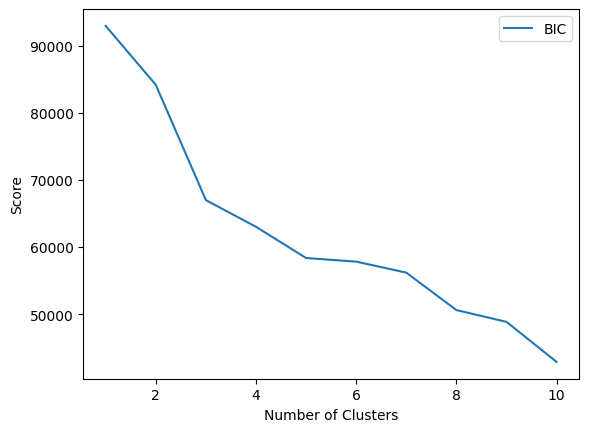

In [337]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

n_components = range(1, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(x_log_rscaled_reduced)
          for n in n_components]

plt.plot(n_components, [m.bic(x_log_rscaled_reduced) for m in models], label='BIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

In [355]:
n_clusters = 10

gmm = GaussianMixture(
    n_components=n_clusters,
    covariance_type='full',
    random_state=42
)

# Fit on your PCA-reduced data
gmm_labels = gmm.fit_predict(x_log_rscaled_reduced)

# Add to your dataframe
gmmX["cluster"] = gmm_labels

avg_log_likelihood = gmm.score(x_log_rscaled_reduced)
total_log_likelihood = avg_log_likelihood * X.shape[0]

print(total_log_likelihood)

# Check the distribution
print(gmmX["cluster"].value_counts())


-20778.604925234806
cluster
1    1388
2    1291
9    1176
8     913
7     845
0     782
4     599
5     384
6     382
3     240
Name: count, dtype: int64


In [356]:
profile = gmmX.groupby('cluster').agg({
    'packet_count': 'mean',
    # 'bytes_out': 'mean',
    'bytes_in': 'mean',
    'payload_ratio': 'mean',
    'burst_ratio': 'mean',
    'small_iat_count': 'mean',
    'avg_iat_micros': 'mean',
    'byte_count': 'mean',
    'flow_duration': 'mean',
    # 'p1_len': 'mean'
}).round(2)

print(profile)

         packet_count   bytes_in  payload_ratio  burst_ratio  small_iat_count  \
cluster                                                                         
0                7.44       0.00           0.00         0.00             0.00   
1                8.09       0.00           0.00         0.41             3.28   
2              118.22       1.00           0.00         0.36            45.61   
3              159.24  200783.76          21.16         0.68           135.41   
4                6.82     319.85           2.25         0.31             2.16   
5               10.00     106.89           0.14         0.16             1.60   
6              104.95   10452.25           1.23         0.34            32.90   
7               15.76       0.00           0.00         0.57             9.15   
8               30.50       0.00           0.00         0.08             0.68   
9               12.31    1452.27           1.41         0.34             4.66   

         avg_iat_micros  by

In [340]:
# 1. Map your Cluster IDs to your Thesis Labels
# Based on the profiles we saw: 0=Background, 1=Browsing, 2=VoIP, 3=Streaming


# Assign the cluster labels to the original df DataFrame
# 2. Fix the Sizing Logic
# We use log1p to compress the size range so points aren't invisible
# Then we add a constant (+5) so the smallest points are still clickable
point_size = np.log1p(df['packet_count']) + 5

fig = px.scatter_3d(
    gmmX,
    x=x_log_rscaled_reduced[:, 0],
    y=x_log_rscaled_reduced[:, 1],
    z=x_log_rscaled_reduced[:, 2],
    color='cluster',
    symbol='cluster',
    size=point_size,       # Scaled sizes
    opacity=1,
    hover_data={           # See features when you hover over a point
        'packet_count': True,
        'byte_count': True,
        'payload_ratio': ':.2f',
        'small_iat_count': True
    },
    title="3D Behavioral Clustering of Encrypted Traffic",
    labels={'x': 'PC0 (Duration/IAT)', 'y': 'PC1 (Identity)', 'z': 'PC2 (Symmetry)'},
    color_discrete_sequence=px.colors.qualitative.Vivid
)

# 3. Clean up the layout
fig.update_layout(
    legend_title_text='Activity Type',
    margin=dict(l=0, r=0, b=0, t=40),
    scene=dict(
        xaxis_title='Duration/IAT',
        yaxis_title='Identity (P1-P5)',
        zaxis_title='Symmetry (Ratio)'
    )
)

fig.show()

In [345]:
kmeans_metrics(x_log_rscaled_reduced, gmm_labels)

Silhouette Score: 0.24883828626444784
Davies-Bouldin Score: 1.431175543102761
Calinski-Harabasz Score: 1915.1176179803113
